# load

> Module for loading training and target files

In [ ]:
#| default_exp load

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export

import numpy as np
import pkg_resources
from sepia.SepiaData import SepiaData
import matplotlib.pylab as plt


In [ ]:
#| hide

import os
from scipy.interpolate import interp1d


In [ ]:
#| hide 

if_local_processing = False


In [ ]:
#| export

DATA_DIR = "data/pkg_data/"
LIBRARY_PARAM_FILE = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "params_latin.txt").name
LIBRARY_PK_FILE = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "pk_all.npy").name
LIBRARY_K_FILE = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "k_all.npy").name
LIBRARY_Z_FILE = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "z_all.npy").name


LIBRARY_PARAM_FILE_TEST = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "params_latin_test.txt").name
LIBRARY_PK_FILE_TEST = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "pk_all_test.npy").name
LIBRARY_K_FILE_TEST = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "k_all_test.npy").name
LIBRARY_Z_FILE_TEST = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "z_all_test.npy").name


OBS_DIR = "data/obs_data/"
SDSS_FILE = pkg_resources.resource_stream("EarlyDarkEmu", OBS_DIR + "reid_DR7.txt").name
WMAP_FILE = pkg_resources.resource_stream("EarlyDarkEmu", OBS_DIR + "wmap_act.txt").name


PARAM_NAME = [r"$\omega_m$", r"h", r"$\sigma_8$", r"$\log(z_c)$", r"$f_{ede}$", r"$\theta_i$"]

# LIBRARY_ZK_FILE_VAL = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "z_k_validation.txt").name
# LIBRARY_BK_FILE_VAL = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "Boost_validation.npy").name
# LIBRARY_PARAM_FILE_VAL = pkg_resources.resource_stream("EarlyDarkEmu", DATA_DIR + "cosmo_validation.txt").name


In [ ]:
#| hide

def load_single_pk(file_path
                   ):
    data = np.loadtxt(file_path).T
    return data

In [ ]:
#| hide

def interpolate_data(k, 
                     pk, 
                     k_base
                     ):
    interp_func = interp1d(k, pk, kind='linear', bounds_error=False, fill_value="extrapolate")
    pk_interpolated = interp_func(k_base)
    return pk_interpolated

In [ ]:
#| hide

def extract_z_value(file_path
                    ):
    with open(file_path, 'r') as file:
        first_line = file.readline()
        z_value = float(first_line.split('z=')[1].split()[0])
    return z_value

In [ ]:
#| hide

def load_all_save_npy(directory, 
                       k_base, 
                       output_directory,
                       total_sim_num=64, 
                       total_redshift_num=51, 
                       if_train=True
                       ):
    
    all_data = np.zeros((total_sim_num, total_redshift_num, len(k_base)))
    all_z = np.zeros(total_redshift_num, )

    for sim_num in range(1, total_sim_num + 1):
        sim_data = []
        
        
        for redshift_num in range(1, total_redshift_num + 1):

            if if_train: file_name = f"EDE_model{sim_num}_00_z{redshift_num}_pk.dat"
            else: file_name = f"EDE_test{sim_num}_00_z{redshift_num}_pk.dat"
            
            file_path = os.path.join(directory, file_name)
            k, pk = load_single_pk(file_path)
            # print(k.min(), k.max())
            pk_interpolated = interpolate_data(k, pk, k_base)  
            sim_data.append(pk_interpolated)


            if sim_num == 1: 
                
                z_single = extract_z_value(file_path)
                all_z[redshift_num -1] = z_single

        
        all_data[sim_num - 1, :, :] = np.array(sim_data)  # Adjusted index to be 0-based

    # np.save(output_directory + 'pk_all', all_data, allow_pickle=True)
    # all_data = np.ravel(all_data)
    
    if if_train: 
        np.save(output_directory + 'pk_all.npy', all_data)
        np.save(output_directory + 'k_all.npy', k_base)
        np.save(output_directory + 'z_all.npy', all_z)
    
    else: 
        np.save(output_directory + 'pk_all_test.npy', all_data)
        np.save(output_directory + 'k_all_test.npy', k_base)
        np.save(output_directory + 'z_all_test.npy', all_z)

    return all_data, k_base, all_z


In [ ]:
#| export 

_k_base = np.logspace(-5,  0, 210)
print(_k_base.shape)

(210,)


In [ ]:
#| hide


if if_local_processing:
    
    
    out_dir = '/home/nramachandra/Projects/MG_emu/Codes/EarlyDarkEmu/EarlyDarkEmu/data/pkg_data/'

    file_dir = '/home/nramachandra/Projects/MG_emu/Data/raw_runs/LatinHypercubeRuns_AllRedshifts/'
    Pk_all, k_all, z_all = load_all_save_npy(file_dir, 
                                            output_directory = out_dir, 
                                            k_base=_k_base,
                                            total_sim_num=64, 
                                            total_redshift_num=51, 
                                            if_train=True)
    
    file_dir = '/home/nramachandra/Projects/MG_emu/Data/raw_runs/LatinHypercubeRuns_AllRedshifts_Test/'
    Pk_all_test, k_all_test, z_all_test = load_all_save_npy(file_dir, 
                                                            output_directory = out_dir, 
                                                            k_base=_k_base, 
                                                            total_sim_num=6, 
                                                            total_redshift_num=101, 
                                                            if_train=False)

In [ ]:
#| export

def load_npy_pk_k_z(Pk_fileIn:str=LIBRARY_PK_FILE, # Input file for Pk
                     k_fileIn:str=LIBRARY_K_FILE,  # Input file for k
                     z_fileIn:str=LIBRARY_Z_FILE, # Input file for z
                     pk_log_scale:bool=True, #log10 scaling for P(k)
                     ) -> tuple:#Three n-D arrays for P(k), k and z


    # Pk_all = np.load(Pk_fileIn, allow_pickle=True, encoding='latin1')
    Pk_all = np.load(Pk_fileIn)
    k_all = np.load(k_fileIn)
    z_all = np.load(z_fileIn)

    # Pk_all = np.reshape(Pk_all, newshape=(-1, z_all.shape[0], k_all.shape[0]))
    
    if pk_log_scale: 
        Pk_all = np.log10(Pk_all)        

    return Pk_all, k_all, z_all


In [ ]:
#| export

if True: 
    Pk_all, k_all, z_all = load_npy_pk_k_z(LIBRARY_PK_FILE, LIBRARY_K_FILE, LIBRARY_Z_FILE)

    Pk_all_test, k_all_test, z_all_test = load_npy_pk_k_z(LIBRARY_PK_FILE_TEST, LIBRARY_K_FILE_TEST, LIBRARY_Z_FILE_TEST)

In [ ]:
# Pk_all_ravel = np.ravel(Pk_all)

# Pk_all_reshaped = np.reshape(Pk_all_ravel, newshape=(-1, z_all.shape[0], k_all.shape[0]))

# (Pk_all_reshaped == Pk_all).all()

In [ ]:
#| export 

def load_sdss(fileIn:str=SDSS_FILE, #Input file
              ):
    k, pk, pk_error = np.loadtxt(fileIn, delimiter=' ').T
    return k, np.log10(pk), np.abs(pk_error/pk)

In [ ]:
#| export 

def load_wmap(fileIn:str=WMAP_FILE, #Input file
              ):
    k, pk, pk_error = np.loadtxt(fileIn).T
    return k, np.log10(pk), ((pk_error-pk)/pk)

(array([32]), array([0]), array([127]))


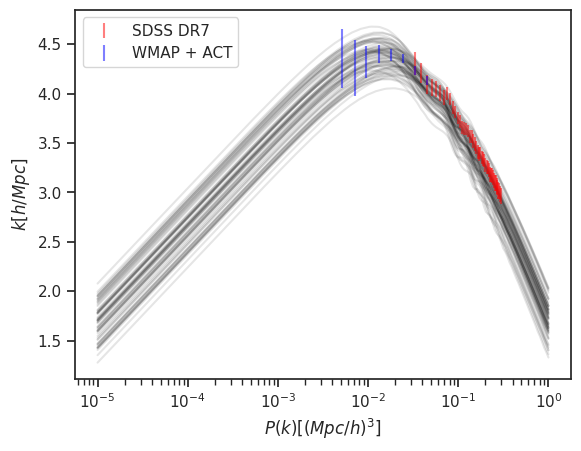

In [ ]:
#| hide


if True:

    print(np.where(Pk_all == np.max(Pk_all)))

    remove_sim_indx = []
    valid_indices = [i for i in  np.arange(Pk_all.shape[0])  if i not in remove_sim_indx]

    Pk_all_clean = Pk_all[valid_indices]


    plt.plot(_k_base, Pk_all[remove_sim_indx, 0, :].T, 'k');
    plt.plot(_k_base, Pk_all[valid_indices, 0, :].T, 'black', alpha=0.1);
    plt.xscale('log')
    # plt.yscale('log')


    k_sdss, pk_sdss, pk_error_sdss = load_sdss()
    k_wmap, pk_wmap, pk_error_wmap = load_wmap()

    plt.errorbar(k_sdss, pk_sdss, yerr=pk_error_sdss, label='SDSS DR7', color='red', ls='none', alpha=0.5) 
    plt.errorbar(k_wmap, pk_wmap, yerr=pk_error_wmap, label='WMAP + ACT', color='blue', ls='none', alpha=0.5) 
    plt.legend()

    plt.ylabel(r'$k [h/Mpc]$')
    plt.xlabel(r'$P(k) [(Mpc/h)^3]$')

In [ ]:
#| hide

if if_local_processing:

    file_dir = '/home/nramachandra/Projects/MG_emu/Data/raw_runs/LatinHypercubeRuns_AllRedshifts/'

    file_pk_trial = 'EDE_model42_00_z1_pk.dat'
    k, pk = load_single_pk(file_dir + file_pk_trial)

    file_pk_trial = 'EDE_model52_00_z1_pk.dat'
    k2, pk2 = load_single_pk(file_dir + file_pk_trial)

    file_pk_trial = 'EDE_model38_00_z1_pk.dat'
    k3, pk3 = load_single_pk(file_dir + file_pk_trial)

    print(k.shape, k2.shape)

    # plt.plot(k, k2[1:], 'x')
    plt.plot(k, np.log10(pk), 'g')
    plt.plot(k2, np.log10(pk2), 'r')
    plt.plot(k3, np.log10(pk3), 'b')

    plt.plot(_k_base, Pk_all[:, 0, :].T, 'k', alpha=0.02);


    plt.errorbar(k_sdss, pk_sdss, yerr=pk_error_sdss)
    plt.errorbar(k_wmap, pk_wmap, yerr=pk_error_wmap)

    plt.xscale('log')




In [ ]:
# #| export

# def load_boost_data(Bk_fileIn:str=LIBRARY_BK_FILE, # Input file for Boost
#                         Zk_fileIn:str=LIBRARY_ZK_FILE, # Input file for redshift and wavenumbers
#                         ) -> tuple: # Boost, wavenumbers, redshifts 
#     Bk_all = np.load(Bk_fileIn)
#     zk_all = np.loadtxt(Zk_fileIn)
    
#     z_all = zk_all[:, 0][np.isfinite(zk_all[:, 0])]
#     k_all = zk_all[:, 1]
    
#     return Bk_all, k_all, z_all

In [ ]:
#| export

def load_params(p_fileIn:str=LIBRARY_PARAM_FILE, # Input file for parameters
               ) -> np.array: # Parameters
    p_all = np.loadtxt(p_fileIn)

    return p_all[:, 1:-1]

In [ ]:
#| hide

if if_local_processing:
    # Bk_all, k_all, z_all = load_boost_data()
    p_all = load_params()
    print(p_all[3])

In [ ]:
#| export

def sepia_data_format(design:np.array=None, # Params array of shape (num_simulation, num_params)
                     y_vals:np.array=None, # Shape (num_simulation, num_y_values)
                     y_ind:np.array=None # Shape (num_y_values,)
                     ) -> SepiaData: #Sepia data format
    sepia_data = SepiaData(t_sim=design, y_sim=y_vals, y_ind_sim=y_ind)
    return sepia_data

In [ ]:
#| hide

if if_local_processing:

    z_index = 0
    y_vals = Pk_all[:, z_index, :]
    y_ind = np.arange(0, y_vals.shape[1])
    sepia_data = sepia_data_format(p_all, y_vals, y_ind)
    print(sepia_data)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()